# Model Comparison

In [2]:
import pandas as pd 
import numpy as np 
import os
import sys
src_path = os.path.abspath(os.path.join('..'))
sys.path.append(src_path)
from utils.constants import PREDICTORS_COMPLETE, PC2, PC3, AVOIDED_NEGATIVE_BONUS, MISSED_POSITIVE_PENALTY
from utils.config.task_extraction_config import *
from utils.config.dashboard_configuration import DASHBOARD_CONFIG
from utils.functions.task_extraction_functions import load_file
from utils.functions.model_comparison_functions import predict_coordinate_pc, calculate_raw_task_score, calculate_all_scores_per_participant
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore, spearmanr
import scikit_posthocs as sp
import ast
import itertools

In [3]:
FILE_PATHS = TASK_EXTRACTION_CONFIG['file_paths']
DASHBOARD_FILE_PATHS = DASHBOARD_CONFIG['file_paths']
df_jobs = load_file(FILE_PATHS['master_jobs_with_umap'])
relevance_feedback = pd.read_excel(FILE_PATHS['dashboard_results'], sheet_name='Relevance Feedback')
print(f"Relevance feedback shape: {relevance_feedback.shape}")
relevance_feedback = relevance_feedback.replace({'Combined': 'Hybrid', 'Preference': 'Task'})
cognitive_data = pd.read_excel(DASHBOARD_FILE_PATHS['cognitive_data1'])
cognitive_data = cognitive_data.rename(columns={'participant_id': 'Participant ID'})
print(f"Cognitive data shape: {cognitive_data.shape}")
task_scores = pd.read_excel(FILE_PATHS['dashboard_results'], sheet_name='Task Scores')
task_scores = task_scores.rename(columns={'meta_task_id': 'meta_task_ids'})
print(f"Task scores shape: {task_scores.shape}")

Relevance feedback shape: (968, 5)
Cognitive data shape: (1156, 18)
Task scores shape: (2460, 4)


### Before Cleaning Outliers

In [4]:
relevance_feedback = relevance_feedback[['Participant ID', 'Job Title', 'Recommendation Type', 'Relevance Score']].copy()
overall_medians = relevance_feedback.groupby('Recommendation Type')['Relevance Score'].median()
overall_medians_wide = overall_medians.to_frame().T
print(f"Overall medians before cleaning: {overall_medians_wide.head()}")
overall_means = relevance_feedback.groupby('Recommendation Type')['Relevance Score'].mean()
overall_means_wide = overall_means.to_frame().T
print(f"Overall means before cleaning: {overall_means_wide.head()}")
cognitive_means = relevance_feedback[relevance_feedback['Recommendation Type'] == 'Cognitive'].copy()
print(f"Information Cognitive Model: {cognitive_means.describe()}")
combined_means = relevance_feedback[relevance_feedback['Recommendation Type'] == 'Hybrid'].copy()
print(f"Information Hybrid Model: {combined_means.describe()}")
preference_means = relevance_feedback[relevance_feedback['Recommendation Type'] == 'Task'].copy()
print(f"Information Task Model: {preference_means.describe()}")
random_means = relevance_feedback[relevance_feedback['Recommendation Type'] == 'Random'].copy()
print(f"Information Random Model: {random_means.describe()}")

Overall medians before cleaning: Recommendation Type  Cognitive  Hybrid  Random  Task
Relevance Score            2.0     3.0     2.0   5.0
Overall means before cleaning: Recommendation Type  Cognitive    Hybrid    Random      Task
Relevance Score       3.086364  3.559091  2.532468  4.927273
Information Cognitive Model:        Relevance Score
count       220.000000
mean          3.086364
std           2.172219
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max           9.000000
Information Hybrid Model:        Relevance Score
count       220.000000
mean          3.559091
std           2.210634
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           9.000000
Information Task Model:        Relevance Score
count       220.000000
mean          4.927273
std           2.361058
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max           9.000000
Informat

### Getting Rid of Non-Variance Responders

In [5]:
by_id = relevance_feedback.groupby('Participant ID')['Relevance Score']
std_devs = by_id.std()
participants_to_keep = std_devs[std_devs >= 1].index
cleaned_df = relevance_feedback[
    relevance_feedback['Participant ID'].isin(participants_to_keep)
]
print(cleaned_df.shape)
print(f"Participants removed due to low std dev: {set(relevance_feedback['Participant ID']) - set(cleaned_df['Participant ID'])}")

(946, 4)
Participants removed due to low std dev: {'BCIS18'}


### Getting Rid of Cognitive Outliers

In [6]:
participant_ids = cleaned_df["Participant ID"].unique()
subset_cognitive = cognitive_data[cognitive_data["Participant ID"].isin(participant_ids)]
subset_cognitive = subset_cognitive[["Participant ID"] + PREDICTORS_COMPLETE]

In [7]:
predictor_cols = PREDICTORS_COMPLETE[:] 
X = subset_cognitive[predictor_cols].apply(pd.to_numeric, errors="coerce")
# Identify zero-variance columns (e.g., Intercept)
zero_var_cols = X.columns[X.nunique(dropna=True) <= 1].tolist()
if zero_var_cols:
    X = X.drop(columns=zero_var_cols)

# Calculate Mahalanobis distance
mu = X.mean(axis=0).values
diff = X.values - mu
cov = np.cov(diff, rowvar=False, ddof=1)
cov_inv = np.linalg.pinv(cov)
md2 = np.einsum('ij,jk,ik->i', diff, cov_inv, diff)

# Chi-squared threshold p < .001
df = X.shape[1]
threshold = chi2.ppf(1 - 0.001, df)

results = subset_cognitive[["Participant ID"]].copy()
results["mahalanobis_sq"] = md2
results["threshold_chi2_0.001_df{}".format(df)] = threshold
results["is_outlier_p<0.001"] = results["mahalanobis_sq"] > threshold
outliers = results[results["is_outlier_p<0.001"]].sort_values("mahalanobis_sq", ascending=False)

print(f"Zero-variance columns dropped: {zero_var_cols}")
print(f"Degrees of freedom used: {df}")
print(f"Chi-square threshold (p<.001): {threshold:.3f}")
print(f"N outliers: {outliers.shape[0]} of {results.shape[0]}")

Zero-variance columns dropped: ['Intercept']
Degrees of freedom used: 16
Chi-square threshold (p<.001): 39.252
N outliers: 0 of 42


/var/folders/dd/jprpsf_n03v2g4wy4c_ksl5w0000gp/T/ipykernel_13655/4088377433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


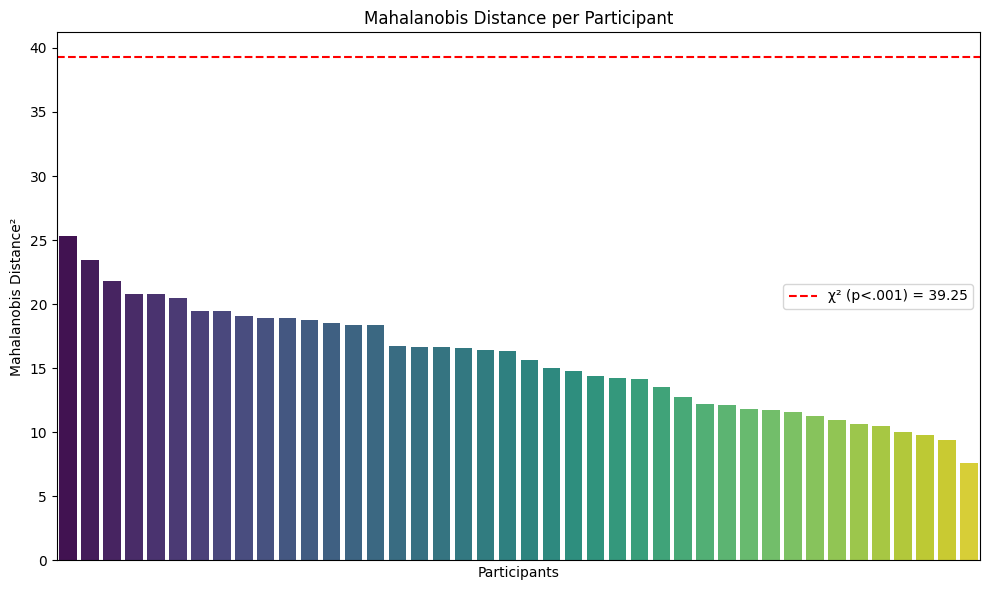

In [8]:
results_sorted = results.sort_values("mahalanobis_sq", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Participant ID",
    y="mahalanobis_sq",
    data=results_sorted,
    palette="viridis"
)
plt.axhline(y=threshold, color="red", linestyle="--", label=f"χ² (p<.001) = {threshold:.2f}")
plt.xticks([], [])
plt.xlabel("Participants")
plt.ylabel("Mahalanobis Distance²")
plt.title("Mahalanobis Distance per Participant")
plt.legend()
plt.tight_layout()
plt.show()

## Clean Descriptives

In [9]:
cleaned_df.head()

,Participant ID,Job Title,Recommendation Type,Relevance Score
0,lars_m,Archaeologist,Task,5
1,lars_m,Pilates Teacher,Task,3
2,lars_m,Fitness Instructor,Task,3
3,lars_m,Biology Technician,Task,7
4,lars_m,Psychologist,Task,8


In [10]:
cleaned_medians = cleaned_df.groupby('Recommendation Type')['Relevance Score'].median()
cleaned_medians_wide = cleaned_medians.to_frame().T
print(f"Overall medians after cleaning: {cleaned_medians_wide.head()}")
cleaned_means = cleaned_df.groupby('Recommendation Type')['Relevance Score'].mean()
cleaned_means_wide = cleaned_means.to_frame().T
print(f"Overall means after cleaning: {cleaned_means_wide.head()}")
cognitive_cleaned = cleaned_df[cleaned_df['Recommendation Type'] == 'Cognitive'].copy()
print(f"Information Cognitive Model: {cognitive_cleaned.describe()}")
combined_cleaned = cleaned_df[cleaned_df['Recommendation Type'] == 'Hybrid'].copy()
print(f"Information Hybrid Model: {combined_cleaned.describe()}")
preference_cleaned = cleaned_df[cleaned_df['Recommendation Type'] == 'Task'].copy()
print(f"Information Task Model: {preference_cleaned.describe()}")
random_cleaned = cleaned_df[cleaned_df['Recommendation Type'] == 'Random'].copy()
print(f"Information Random Model: {random_cleaned.describe()}")

Overall medians after cleaning: Recommendation Type  Cognitive  Hybrid  Random  Task
Relevance Score            2.0     3.0     2.0   5.0
Overall means after cleaning: Recommendation Type  Cognitive    Hybrid   Random      Task
Relevance Score       3.116279  3.590698  2.54485  4.986047
Information Cognitive Model:        Relevance Score
count       215.000000
mean          3.116279
std           2.185437
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max           9.000000
Information Hybrid Model:        Relevance Score
count       215.000000
mean          3.590698
std           2.223474
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           9.000000
Information Task Model:        Relevance Score
count       215.000000
mean          4.986047
std           2.355108
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max           9.000000
Information 

In [11]:
df_agg = cleaned_df.groupby(['Participant ID', 'Recommendation Type'])['Relevance Score'].median().reset_index()
df_wide = df_agg.pivot(index='Participant ID', 
                       columns='Recommendation Type', 
                       values='Relevance Score')
df_wide_complete = df_wide.dropna()
df_wide_complete.head()
df_rested = df_wide_complete.reset_index()
df_rested[['Cognitive', 'Hybrid', 'Task', 'Random']].describe()

Recommendation Type,Cognitive,Hybrid,Task,Random
count,42.000000,42.000000,42.000000,42.000000
mean,3.071429,3.285714,4.880952,1.952381
std,2.076499,2.015618,2.062468,1.010973
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.250000,4.000000,1.000000
50%,2.500000,3.000000,5.000000,2.000000
75%,5.000000,4.750000,7.000000,3.000000
max,8.000000,8.000000,8.000000,5.000000


In [12]:
df_rested[['Cognitive', 'Hybrid', 'Task', 'Random']].median()

Recommendation Type
Cognitive    2.5
Hybrid       3.0
Task         5.0
Random       2.0
dtype: float64

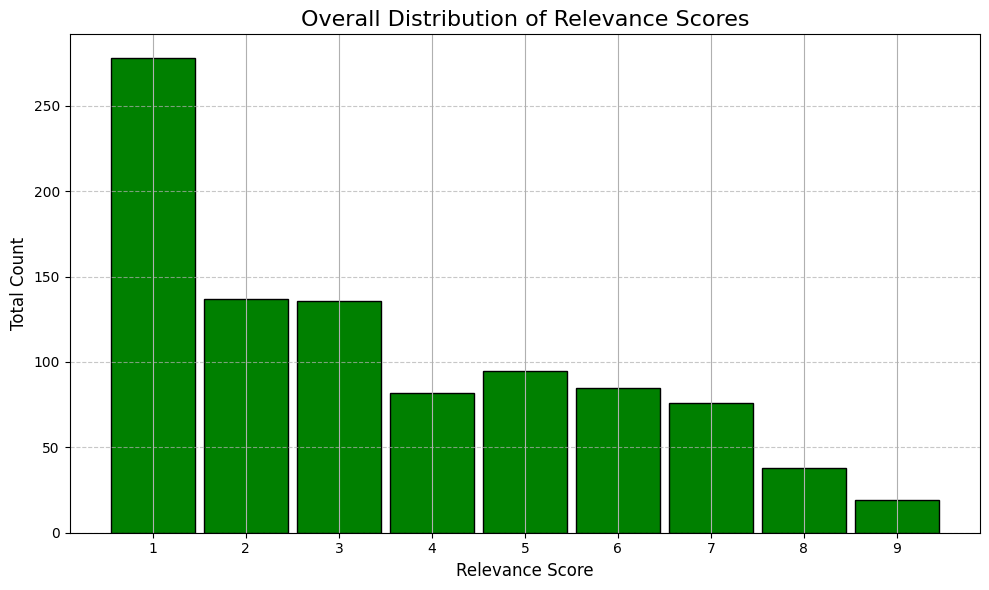

In [13]:
plt.figure(figsize=(10, 6))
bins = [x + 0.5 for x in range(0, 10)]
cleaned_df['Relevance Score'].hist(bins=bins, edgecolor='black', rwidth=0.9, color='green')
plt.title('Overall Distribution of Relevance Scores', fontsize=16)
plt.xlabel('Relevance Score', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.xticks(range(1, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This is a right-skewed distribtuion. Participants overwhelmingly rated the recommendations on the "Non Relevant" end of the scale. The score 1 is by far the most frequent response with a count of over 270. This is more than double any other single rating. When combining scores 1, 2, and 3, they account for the vast majority of all ratings. On average, the jobs shown were not a good fit for the participants. 

A positive finding is that participants used the full scale. Rating of 9 and especially 9 were the least common. This means participants were very selective and it was difficult to get a top score. A model that does manage to get 8s and 9s is doing something significantly better. 

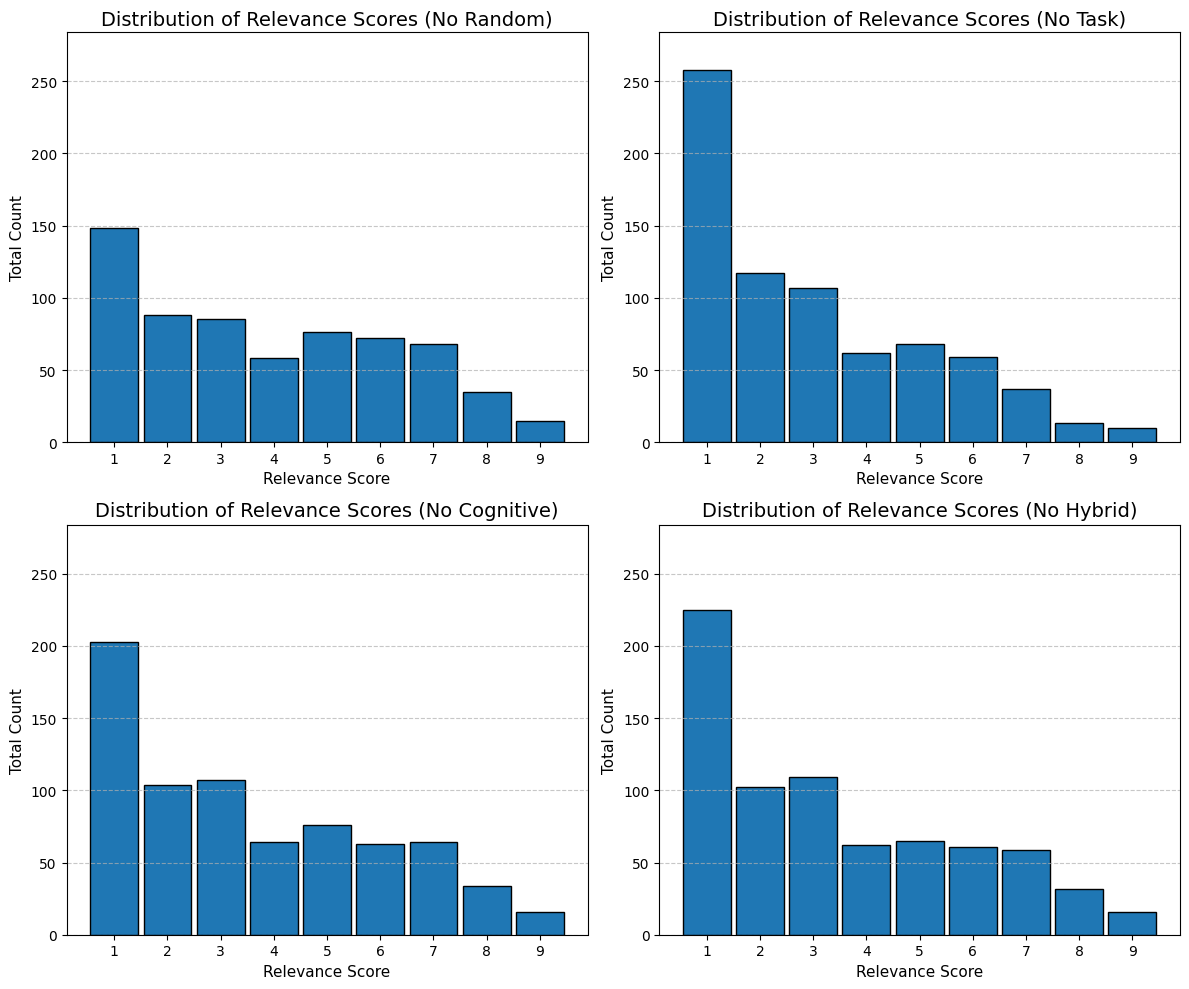

In [14]:
subsets = {
    'No Random': cleaned_df[cleaned_df['Recommendation Type'] != 'Random'],
    'No Task': cleaned_df[cleaned_df['Recommendation Type'] != 'Task'],
    'No Cognitive': cleaned_df[cleaned_df['Recommendation Type'] != 'Cognitive'],
    'No Hybrid': cleaned_df[cleaned_df['Recommendation Type'] != 'Hybrid']
}

bins = [x + 0.5 for x in range(0, 10)]
max_y = 0
for df in subsets.values():
    counts, _ = np.histogram(df['Relevance Score'], bins=bins)
    max_y = max(max_y, counts.max())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (title, df) in zip(axes, subsets.items()):
    ax.hist(df['Relevance Score'], bins=bins, edgecolor='black', rwidth=0.9)
    ax.set_title(f'Distribution of Relevance Scores ({title})', fontsize=14)
    ax.set_xlabel('Relevance Score', fontsize=11)
    ax.set_ylabel('Total Count', fontsize=11)
    ax.set_xticks(range(1, 10))
    ax.set_ylim(0, max_y * 1.1) 
    ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

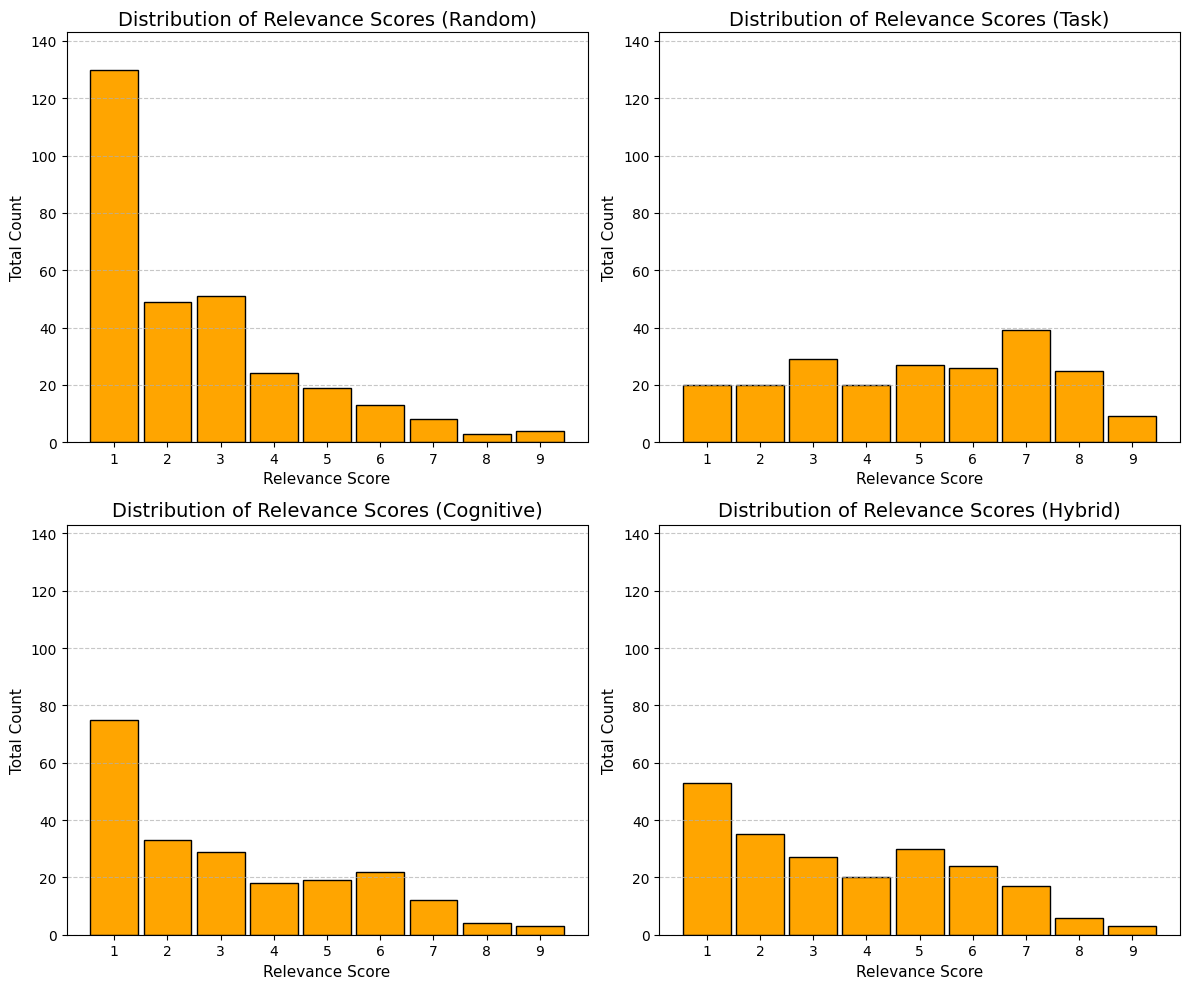

In [15]:
subsets_2 = {
    'Random': cleaned_df[cleaned_df['Recommendation Type'] == 'Random'],
    'Task': cleaned_df[cleaned_df['Recommendation Type'] == 'Task'],
    'Cognitive': cleaned_df[cleaned_df['Recommendation Type'] == 'Cognitive'],
    'Hybrid': cleaned_df[cleaned_df['Recommendation Type'] == 'Hybrid']
}

bins = [x + 0.5 for x in range(0, 10)]
max_y = 0
for df in subsets_2.values():
    counts, _ = np.histogram(df['Relevance Score'], bins=bins)
    max_y = max(max_y, counts.max())
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (title, df) in zip(axes, subsets_2.items()):
    ax.hist(df['Relevance Score'], bins=bins, edgecolor='black', rwidth=0.9, color='orange')
    ax.set_title(f'Distribution of Relevance Scores ({title})', fontsize=14)
    ax.set_xlabel('Relevance Score', fontsize=11)
    ax.set_ylabel('Total Count', fontsize=11)
    ax.set_xticks(range(1, 10))
    ax.set_ylim(0, max_y * 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

1. Random Model: positively-skewed. The 1 bar is by far the largest, and the counts decrease as the score gets higher. the baseline is performing poorly and randomly. is confirms that it is hard getting a good score. 
2. Cognitive Model: positively-skewed. The 1 bar is much smaller than Random's, and there are more scores in the 2-6 range. However, it's still producing far more "Not-relevant" (1-3) scores than Relevant (7-9) scores. Better than random but not great.
3. Combined Model: the 1 bar is even smaller. Still right-skewed but you can see the weight of the distribution shifting to the right (towards 3-5). 
4. Preference Model: the star of the show. it is the only model that is not dominated by 1s. The most common scores are in the 6-8 range. It is actively prodcing good recommendations. 

### Data for Correlation Plot (in R)

In [16]:
my_data = cleaned_df.groupby(['Participant ID', 'Recommendation Type'])['Relevance Score'].mean()
my_data = my_data.reset_index()
my_data_pivot = my_data.pivot(index='Participant ID', columns='Recommendation Type', values='Relevance Score').reset_index()
my_data_pivot.head()

Recommendation Type,Participant ID,Cognitive,Hybrid,Random,Task
0,B7P6ZC,1.0,1.0,1.714286,6.4
1,BCIS1,3.8,3.8,4.428571,3.0
2,BCIS13,6.8,6.8,2.000000,5.6
3,BCIS16,4.0,3.2,3.285714,4.2
4,BCIS2,1.0,2.8,1.714286,1.2


### Distribution Plot

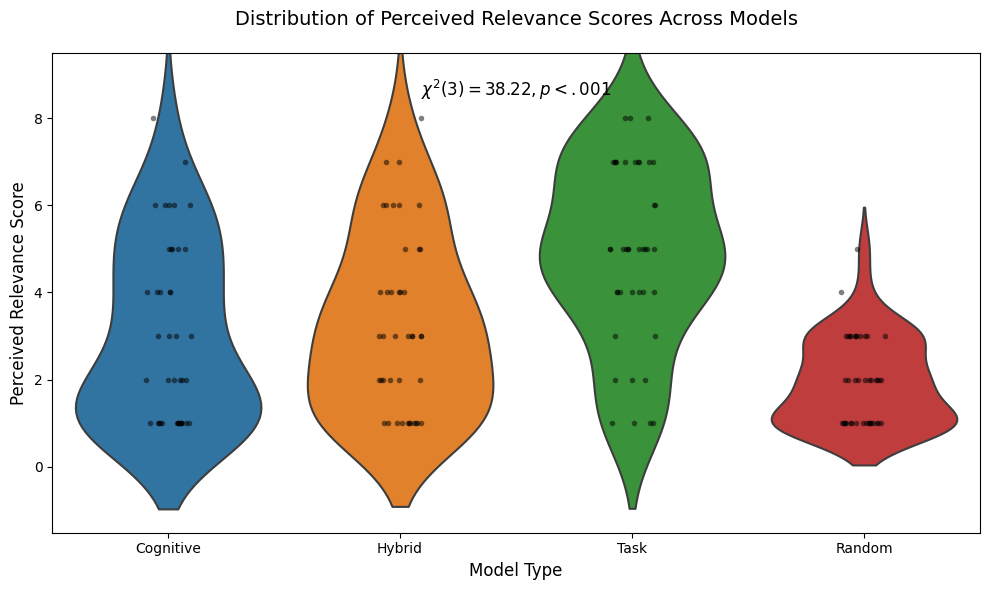

In [22]:
plt.figure(figsize=(10, 6))
plot_data = df_wide_complete[['Cognitive', 'Hybrid', 'Task', 'Random']]
sns.violinplot(data=plot_data, inner=None, linewidth=1.5)
sns.stripplot(data=plot_data, jitter=True, color="black", alpha=0.5, size=4)
y_max = plot_data.max().max()
plt.text(x=1.5,                      
         y=y_max + 0.5,               
         s=r"$\chi^2(3) = 38.22, p < .001$",  
         fontsize=12, 
         ha='center', 
         fontweight='bold')

plt.title("Distribution of Perceived Relevance Scores Across Models", fontsize=14, pad=20)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("Perceived Relevance Score", fontsize=12)

plt.ylim(None, y_max + 1.5)

plt.tight_layout()
plt.show()

## Criterion Validity

In [18]:
try:
    jobs_df = df_jobs[['job_title', 'meta_task_ids', 'PC2', 'PC3', 'job_code']].copy()
    jobs_df['meta_task_ids'] = jobs_df['meta_task_ids'].apply(ast.literal_eval)
except KeyError as e:
    print(f"Error: Main 'df' is missing a required column: {e}")
except Exception as e:
    print(f"An error occurred preparing jobs_df: {e}")
print("jobs_df prepared successfully.")

all_scores_df = calculate_all_scores_per_participant(
    task_scores,
    subset_cognitive,
    jobs_df,
    PC2, 
    PC3, 
    AVOIDED_NEGATIVE_BONUS,
    MISSED_POSITIVE_PENALTY
)

print("\n--- All Scores DataFrame Head ---")
print(all_scores_df[['Participant ID', 'job_title', 'task_score', 'cognitive_score', 'hybrid_score']].head())

preference_relevance_df = cleaned_df[
    cleaned_df['Recommendation Type'] == 'Task'
].copy()
preference_relevance_df = preference_relevance_df[
    ['Participant ID', 'Job Title', 'Relevance Score']
]
preference_relevance_df.rename(columns={'Job Title': 'job_title'}, inplace=True)

merged_scores_df = pd.merge(
    all_scores_df,
    preference_relevance_df,
    on=['Participant ID', 'job_title'],
    how='inner'
)

print("\n--- Merged DataFrame for Correlation ---")
print(merged_scores_df[['Participant ID', 'job_title', 'task_score', 'cognitive_score', 'hybrid_score', 'Relevance Score']].head())

if len(merged_scores_df) < 2:
    print("Correlation cannot be calculated: Not enough matching data points (need at least 2).")
else:
    merged_scores_df.dropna(subset=['task_score', 'cognitive_score', 'hybrid_score', 'Relevance Score'], inplace=True)
    
    if len(merged_scores_df) < 2:
         print("Correlation cannot be calculated: Not enough non-NaN data points.")
    else:
        print(f"\n--- Criterion Validity Analysis (n={len(merged_scores_df)}) ---")
        rho_task, p_task = spearmanr(
            merged_scores_df['task_score'], 
            merged_scores_df['Relevance Score']
        )
        print("\nTask Score vs. Relevance:")
        print(f"  Spearman's rho (ρ): {rho_task:.4f}")
        print(f"  P-value: {p_task:.6f}")

        rho_cog, p_cog = spearmanr(
            merged_scores_df['cognitive_score'], 
            merged_scores_df['Relevance Score']
        )
        print("\nCognitive Score vs. Relevance:")
        print(f"  Spearman's rho (ρ): {rho_cog:.4f}")
        print(f"  P-value: {p_cog:.6f}")
        
        rho_hybrid, p_hybrid = spearmanr(
            merged_scores_df['hybrid_score'], 
            merged_scores_df['Relevance Score']
        )
        print("\nHybrid Score vs. Relevance:")
        print(f"  Spearman's rho (ρ): {rho_hybrid:.4f}")
        print(f"  P-value: {p_hybrid:.6f}")

jobs_df prepared successfully.
Skipping Participant ID BCIS18: Missing cognitive data or task data.

--- All Scores DataFrame Head ---
        Participant ID                job_title  task_score  cognitive_score  \
0  maciekfpied20dncr2r        Secretary General   89.655172         9.730475   
1  maciekfpied20dncr2r  Chief Executive Officer   89.655172        11.426801   
2  maciekfpied20dncr2r  Chief Operating Officer   89.655172        11.426801   
3  maciekfpied20dncr2r  Airport Chief Executive   82.758621        11.426801   
4  maciekfpied20dncr2r      Social Entrepreneur   89.655172        11.426801   

   hybrid_score  
0      0.783692  
1      0.859098  
2      0.859098  
3      0.666299  
4      0.859098  

--- Merged DataFrame for Correlation ---
        Participant ID                 job_title  task_score  cognitive_score  \
0  maciekfpied20dncr2r  Chief Technology Officer   93.103448        20.549413   
1  maciekfpied20dncr2r         Logistics Analyst  100.000000        25.6

## Friedman Test

In [19]:
samples = [df_wide_complete[col] for col in ["Task", "Cognitive", "Hybrid", "Random"]]
f_stat, p_value = stats.friedmanchisquare(*samples)
print("\n--- Friedman Test Results ---")
print(f"Friedman Statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: There is a significant difference between at least two of the models.")
else:
    print("Result: There is no significant difference between the models.")


--- Friedman Test Results ---
Friedman Statistic: 38.2215
P-value: 0.0000
Result: There is a significant difference between at least two of the models.


In [20]:
posthoc_wilcoxon_results = sp.posthoc_wilcoxon(df_agg,
                                               group_col="Recommendation Type",
                                               val_col="Relevance Score",
                                               p_adjust='bonferroni')

print("--- Corrected Wilcoxon Post-Hoc p-values ---")
print(posthoc_wilcoxon_results)

--- Corrected Wilcoxon Post-Hoc p-values ---
           Cognitive    Hybrid    Random      Task
Cognitive   1.000000  0.589453  0.002161  0.005789
Hybrid      0.589453  1.000000  0.000199  0.006640
Random      0.002161  0.000199  1.000000  0.000002
Task        0.005789  0.006640  0.000002  1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1485978c0>)

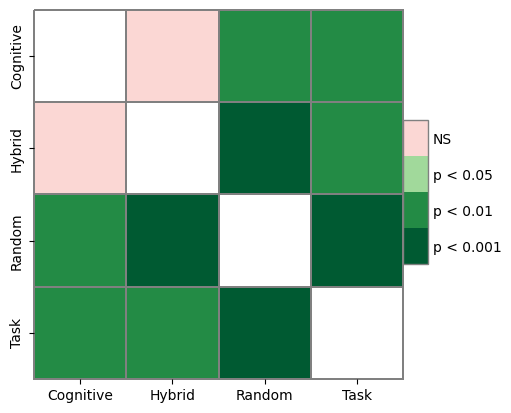

In [21]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_wilcoxon_results, **heatmap_args)